## Linear Regression

This section will cover the Bayesian approach to fitting linear regressions and linear models.  Linear regression is a simple way to relate a response variable to several explanatory variables.  A linear regression model takes the following form: 

$y_i = {\beta}_0 + {\beta}_1 {x_1}_i + ... + B_k {x_k}_i +{\epsilon}$

${\epsilon}_i \sim N(0, {\sigma^2}), i = 1, 2, ..., n$ where ${\epsilon}_i$ is independent and identically distributed

As such, $y_i | \tilde{x}_i, \tilde{\beta}, {\sigma^2} \sim N({\beta}_0 + {\beta}_1 {x_1}_i + ... +{\beta}_k {x_k}_i, {\sigma^2})$

For the prior distributions of the $\beta_0, \beta_1, ...$ the most common choice of priors is a normal distribution $N(\mu, \sigma)$ or one could use a multivariate normal for all the betas at once.  This is conditionally conjugate and allows Gibbs sampling.  To be non-informative, one may choose normal prior distributions with a very large variance.  One can also use the conditionally conjugate inverse gamma prior for the ${\sigma}^2$ term.  Another common prior for the ${\beta}'s$ is the double exponential or Laplace prior.

The Laplace prior $p(\beta) = \frac{1}{2} {e}^{-|{\beta}|}$


In [1]:
## Develop linear model in Julia using Turing

In [2]:
using Turing
using Distributions

using CSV
using DataFrames
using StatsPlots

##  Alternative method to load RDataset

using RDatasets

leonhardt_df = RDatasets.dataset("car", "Leinhardt")

In [63]:
file = pwd() * "/datasets/dataset-37215.csv"

f = open(file)

IOStream(<file /home/gevans/Documents/Dev/Julia/Coursera Bayesian Statistic/datasets/dataset-37215.csv>)

In [64]:
# leinhardt_df = DataFrames(CSV.File(f))
leinhardt_df = DataFrame!(CSV.read(file))
# leinhardt_df = CSV.read(file);

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/gevans/.julia/packages/CSV/OM6FO/src/CSV.jl:40


In [65]:
first(leinhardt_df, 5)

,country,income,infant,region,oil
,String,Int64,String,String,String
1,Australia,3426,26.7,Asia,no
2,Austria,3350,23.7,Europe,no
3,Belgium,3346,17,Europe,no
4,Canada,4751,16.8,Americas,no
5,Denmark,5029,13.5,Europe,no


In [66]:
describe(leinhardt_df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,country,,Afganistan,,Zambia,105,,String
2,income,998.067,50,334.0,5596,,,Int64
3,infant,,10.1,,NA,93,,String
4,region,,Africa,,Europe,4,,String
5,oil,,no,,yes,2,,String


In [67]:
# clean up the infant col to remove NA
leinhardt_df.infant = map(x->(v = tryparse(Float64, x); v == nothing ? 0.0 : v), leinhardt_df.infant);


In [71]:
# clean up the oil column
leinhardt_df.oil = map(x->(x == "no" ? 0 : 1), leinhardt_df.oil);

In [72]:
describe(leinhardt_df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,country,,Afganistan,,Zambia,105,,String
2,income,998.067,50,334.0,5596,,,Int64
3,infant,85.6552,0.0,59.6,650.0,,,Float64
4,region,,Africa,,Europe,4,,String
5,oil,1.0,1,1.0,1,,,Int64


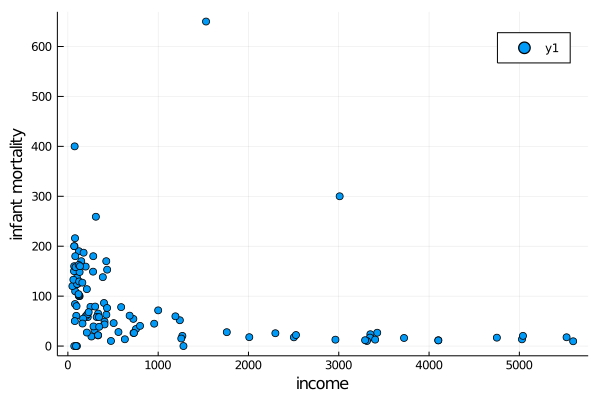

In [81]:
@df leinhardt_df scatter(:income, :infant, xlabel="income", ylabel="infant mortality")

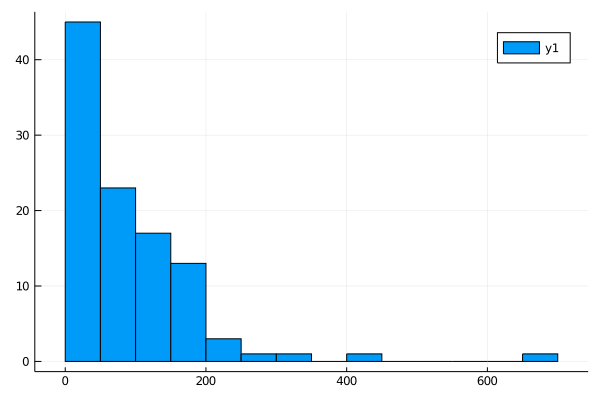

In [85]:
histogram(leinhardt_df.infant)

In [94]:
# Natural log of infant mortality and income
log_infant = map(x-> log(x), leinhardt_df.infant);
log_income = map(x-> log(x), leinhardt_df.income);

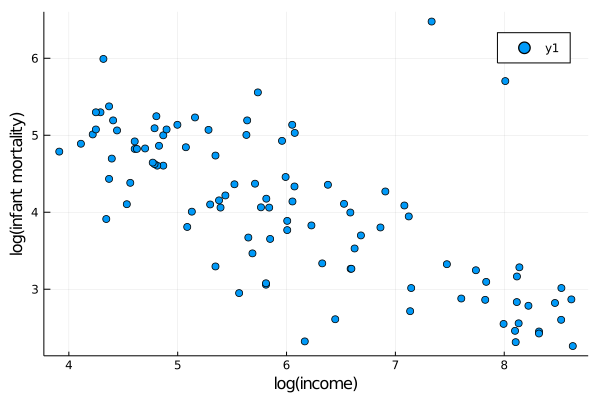

In [97]:
scatter(log_income, log_infant, xlabel = "log(income)", ylabel = "log(infant mortality)")